In [8]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

In [9]:
#Fragen Aufgabenstellung:
        
    #Können wir aus den Bondaten irgendwelche Erkenntisse gewinnen? -> Unsupervised RFM Analyse
    #Gibt es Kuden, die sehr stark in bestimmten Warengruppen kaufen? -> EDA
    #Gibt es Kunden die immer nur zu bestimmten Tagen oder Monaten bei uns einkaufen? -> EDA
    

#Vorgehen
# 1. Hochladen und erste Anpassungen an den Daten
# 2. Verstehen der Daten
# 3. Vorbereitung der Daten 
# 4. EDA
    #4.1. Wochentage
    #4.2. Monate
    #4.3. Produktgruppen
# 5. Kundensegmentierung Analyse
#RFM Analysis:
    #1. Wann wurde der letzte Einkauf getätigt
    #2. Wie oft wurde etwas gekauft
    #3. Wie viel Geld wird im Durschnitt Ausgegeben

In [10]:
#1.

#import of csv files 

bondaten = pd.read_csv("Bondaten.CSV", delimiter=';')

artikelstamm = pd.read_csv("Artikelstamm.csv", encoding='latin-1', delimiter=';')


In [11]:
#2
#Join Bondaten/Artikelstamm zu Kundeninformationen


kundeninfo = bondaten.merge(artikelstamm, how='left', on ='ArtikelID')

kundeninfo.head()

#kundeninfo.describe()


# 1. Kaufdatum
# 2. Unique ID des Bon
# 3. Unique ID des Kunden
# 4. Unique ID des Artikels
# 5. Gekaufte Menge
# 6. Gesamt Netto Umsatz (Menge*Stückpreis -> Stückpreis = Umsatz/Menge)
# 7. Bereich des Artikels
# 8. Thema des Artikels
# 9. Unterthema des Artikels



,Datum,BonID,KundenID,ArtikelID,Menge,Umsatz,Bereich,Thema,Unterthema
0,20140111,105455,6389,104791800,2,"4,01680671691894",BAUSTOFFE,BRENNSTOFFE,BRAUNKOHLE BRIKETTS 19%
1,20140111,105455,6389,103389715,12,"39,140186843872",BAUSTOFFE,BRENNSTOFFE,HOLZBRENNSTOFFE 7%
2,20140104,105456,840,107055900,1,"2,34453781127929",HAUSHALTSTECHNIK,LEUCHTMITTEL,ALLGEBRAUCHSLAMPEN
3,20140104,105457,21882,100533417,1,"134,445378112793",INSTALLATION,HEIZUNG & WARMWASSER,HEISSWASSERGERÄTE
4,20140111,105458,24692,103862992,1,"3,18487394332885",INSTALLATION,ELEKTROINSTALLATION,STECKERLEISTEN- & VERLÄNGERUNG


In [12]:
#Test ob es Produktgruppen gibt die nicht gekauft wurden

test = bondaten.merge(artikelstamm, how='right', on ='ArtikelID')


print(test.head())

print(test['Bereich'].isnull().values.any())

      Datum   BonID  KundenID  ArtikelID Menge            Umsatz    Bereich  \
0  20141007  156582     16220  105070546     1  1,68067226886749  BAUSTOFFE   
1  20120924   37637      1809  105683238     2           40,3193  BAUSTOFFE   
2  20120901   37704      1809  105683238     2           40,3193  BAUSTOFFE   
3  20121010   42144      1809  105683238    -2          -40,3193  BAUSTOFFE   
4  20120908   38304      1809  105683238     5          100,7983  BAUSTOFFE   

       Thema                      Unterthema  
0  BAUCHEMIE  MINERALISCHE & DIPERSIONSPUTZE  
1  BAUCHEMIE  MINERALISCHE & DIPERSIONSPUTZE  
2  BAUCHEMIE  MINERALISCHE & DIPERSIONSPUTZE  
3  BAUCHEMIE  MINERALISCHE & DIPERSIONSPUTZE  
4  BAUCHEMIE  MINERALISCHE & DIPERSIONSPUTZE  
False


In [13]:
#3.
#Basis unterstanding and transfomation of data

#Change data types

#date time
kundeninfo["Datum"] = pd.to_datetime(kundeninfo["Datum"], format ='%Y%m%d')

#IDs as object for better handeling
kundeninfo['BonID'] = kundeninfo['BonID'].astype(object)

kundeninfo['KundenID'] = kundeninfo['KundenID'].astype(object)

kundeninfo['ArtikelID'] = kundeninfo['ArtikelID'].astype(object)

#information about revene and quantity to float
kundeninfo['Umsatz'] = kundeninfo['Umsatz'].str.replace(',', '.').astype(float)

#kundeninfo['Umsatz'] = pd.to_numeric(kundeninfo['Umsatz'],errors='coerce')

kundeninfo['Menge'] = pd.to_numeric(kundeninfo['Menge'],errors='coerce')


kundeninfo['Monat'] = pd.DatetimeIndex(kundeninfo['Datum']).month

kundeninfo['Jahr'] = pd.DatetimeIndex(kundeninfo['Datum']).year

kundeninfo['Wochentag'] = pd.DatetimeIndex(kundeninfo['Datum']).dayofweek

#print(kundeninfo['Bereich'].unique())


#print(kundeninfo['Thema'].unique())

In [14]:
verkaufinfo = kundeninfo[['Datum','Jahr','Monat', 'Wochentag', 'BonID','KundenID','Umsatz']]

umsatz_kauf = verkaufinfo.groupby(['Datum','Jahr','Monat', 'Wochentag', 'BonID','KundenID'], as_index = False)['Umsatz'].sum()

In [15]:
#4.1. Wochentage 

umsatz_tag = verkaufinfo.groupby(['Wochentag','KundenID'], as_index = False)['Umsatz'].sum()

umsatz_tag = umsatz_tag.sort_values(['KundenID','Umsatz'])

#umsatz_monat['rank_Monat'] = umsatz_monat.groupby(['KundenID'], as_index = False)['Umsatz'].rank(method='min').astype(int)
umsatz_tag['rank_Tag'] = umsatz_tag.groupby(['KundenID'], as_index = False)['Umsatz'].cumcount(ascending=False) + 1


umsatz_tag_best = umsatz_tag.loc[umsatz_tag['rank_Tag'] == 1]

<AxesSubplot: xlabel='Wochentag', ylabel='Umsatz'>

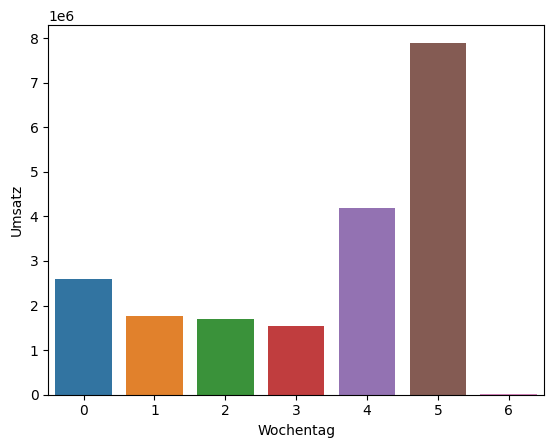

In [16]:
   
#Summe bester Tag berücksichtigt  
sns.barplot(x='Wochentag'
             , y='Umsatz'
             , data = umsatz_tag_best
              ,estimator = np.sum
            ,errorbar=('ci', 0)
             )  
    

<AxesSubplot: xlabel='Wochentag', ylabel='count'>

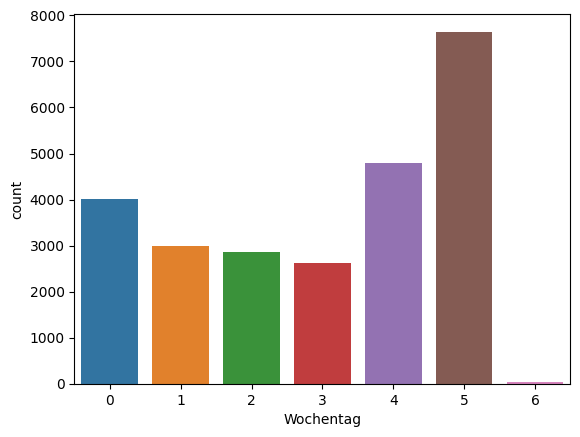

In [17]:
sns.countplot(x='Wochentag', data=umsatz_tag_best)

<AxesSubplot: xlabel='Wochentag', ylabel='Umsatz'>

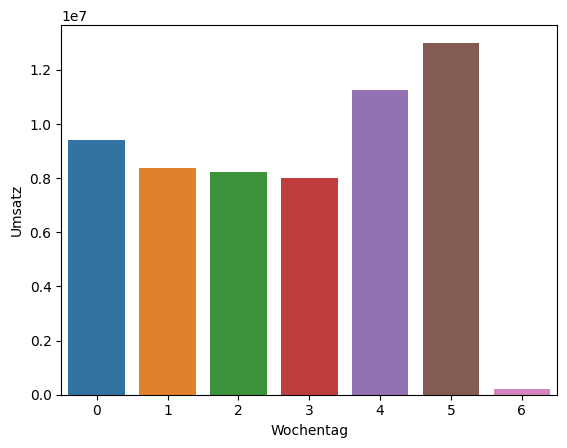

In [18]:

#Summe aller Umsätze berücksichtigt   
sns.barplot(x='Wochentag'
             , y='Umsatz'
             , data = umsatz_tag
              ,estimator = np.sum
            ,errorbar=('ci', 0)
            
             )  

In [19]:
#4.2. Monat

umsatz_monat = verkaufinfo.groupby(['Monat','KundenID'], as_index = False)['Umsatz'].sum()

umsatz_monat = umsatz_monat.sort_values(['KundenID','Umsatz'])

umsatz_monat['rank_Monat'] = umsatz_monat.groupby(['KundenID'], as_index = False)['Umsatz'].cumcount(ascending=False) + 1


umsatz_monat_best = umsatz_monat.loc[umsatz_monat['rank_Monat'] == 1]

<AxesSubplot: xlabel='Monat', ylabel='Umsatz'>

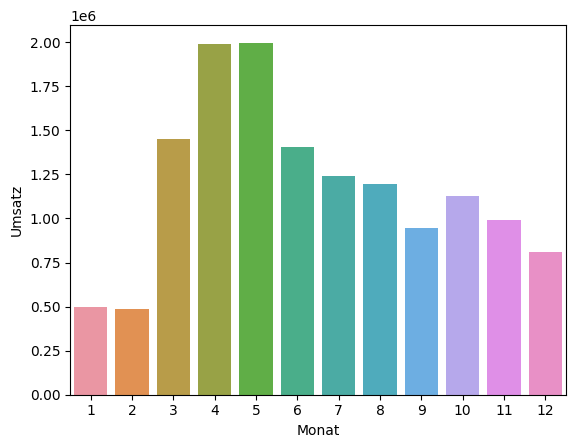

In [20]:
#Summe bester Monat berücksichtigt  
sns.barplot(x='Monat'
             , y='Umsatz'
             , data = umsatz_monat_best
              ,estimator = np.sum
            ,errorbar=('ci', 0)
             )  


<AxesSubplot: xlabel='Monat', ylabel='count'>

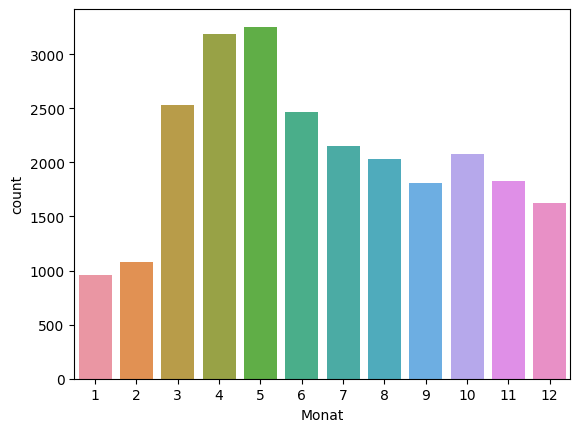

In [21]:
sns.countplot(x='Monat', data=umsatz_monat_best)

<AxesSubplot: xlabel='Monat', ylabel='Umsatz'>

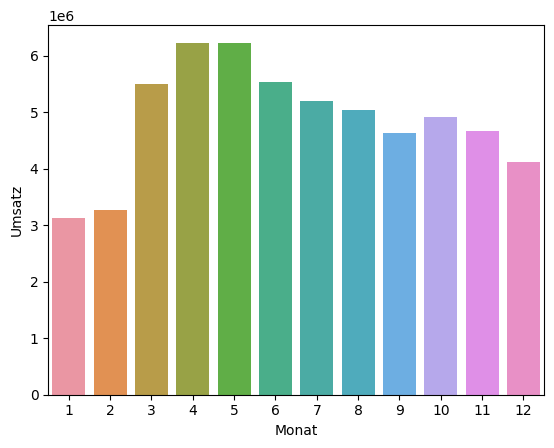

In [22]:
#Summe aller Umsätze berücksichtigt   
sns.barplot(x='Monat'
             , y='Umsatz'
             , data = umsatz_monat
              ,estimator = np.sum
            ,errorbar=('ci', 0)
            
             )  

In [23]:
#4.3. Bereich, Thema, Unterthema


bereich_info = kundeninfo[['KundenID','Bereich','Umsatz']]

thema_info = kundeninfo[['KundenID','Thema','Umsatz']]

uthema_info = kundeninfo[['KundenID','Unterthema','Umsatz']]



umsatz_bereich = bereich_info.groupby(['KundenID','Bereich'], as_index = False)['Umsatz'].sum()

umsatz_thema = thema_info.groupby(['KundenID' ,'Thema'], as_index = False)['Umsatz'].sum()

umsatz_uthema = uthema_info.groupby(['KundenID','Unterthema'], as_index = False)['Umsatz'].sum()


umsatz_bereich = umsatz_bereich.sort_values(['KundenID','Umsatz'])
umsatz_bereich['rank_Bereich'] = umsatz_bereich.groupby(['KundenID'], as_index = False)['Umsatz'].cumcount(ascending=False) + 1

umsatz_bereich_best = umsatz_bereich.loc[umsatz_bereich['rank_Bereich'] == 1]


umsatz_thema = umsatz_thema.sort_values(['KundenID','Umsatz'])
umsatz_thema['rank_Thema'] = umsatz_thema.groupby(['KundenID'], as_index = False)['Umsatz'].cumcount(ascending=False) + 1

umsatz_thema_best = umsatz_thema.loc[umsatz_thema['rank_Thema'] == 1]


umsatz_uthema = umsatz_uthema.sort_values(['KundenID','Umsatz'])
umsatz_uthema['rank_Uthema'] = umsatz_uthema.groupby(['KundenID'], as_index = False)['Umsatz'].cumcount(ascending=False) + 1

umsatz_uthema_best = umsatz_uthema.loc[umsatz_uthema['rank_Uthema'] == 1]


print(umsatz_bereich.loc[umsatz_bereich['KundenID'] == 22392])

        KundenID                         Bereich       Umsatz  rank_Bereich
310268     22392                       HOLZBÖDEN    16.773155            27
310277     22392        WAND & DECKENVERKLEIDUNG    39.453823            26
310258     22392   BODENBELÄGE TEXTIL&KUNSTSTOFF    72.243649            25
310256     22392                             BAD   148.868368            24
310276     22392                  ROHBAUELEMENTE   217.323740            23
310271     22392                  MÖBEL & KÜCHEN   370.176425            22
310262     22392                GARTENDEKORATION   528.687941            21
310263     22392                  GARTENFREIZEIT   564.285509            20
310274     22392                  RAUMDEKORATION   634.546412            19
310279     22392                             ZOO   659.477771            18
310261     22392                         FLIESEN   705.459371            17
310280     22392           ZWEIRÄDER & - ZUBEHÖR   706.899048            16
310267     2

<AxesSubplot: xlabel='Bereich', ylabel='Umsatz'>

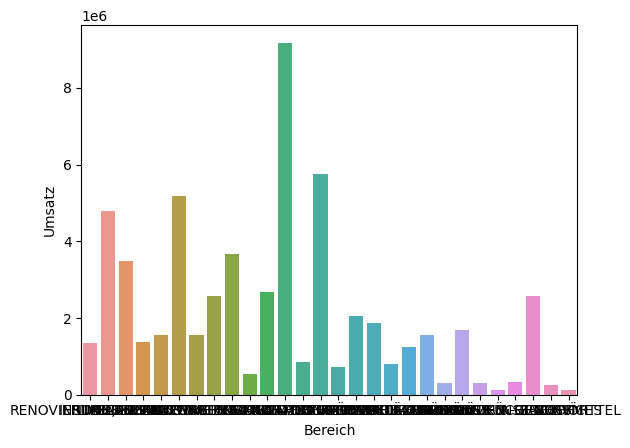

In [24]:
sns.barplot(x='Bereich'
             , y='Umsatz'
             , data = umsatz_bereich
              ,estimator = np.sum
            ,errorbar=('ci', 0)
            
             )  

<AxesSubplot: xlabel='Bereich', ylabel='count'>

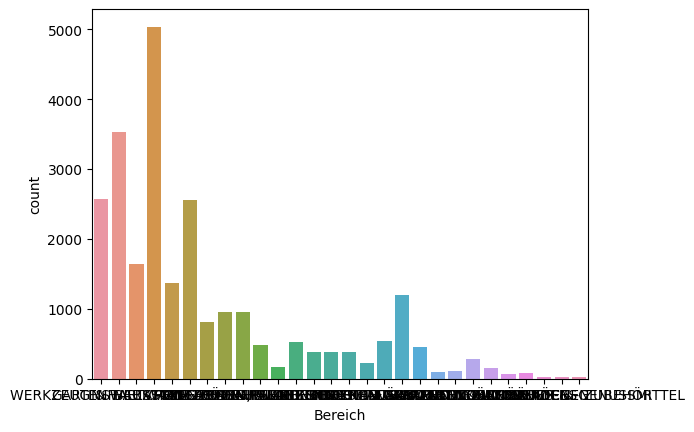

In [25]:
sns.countplot(x='Bereich', data=umsatz_bereich_best)

<AxesSubplot: xlabel='Thema', ylabel='count'>

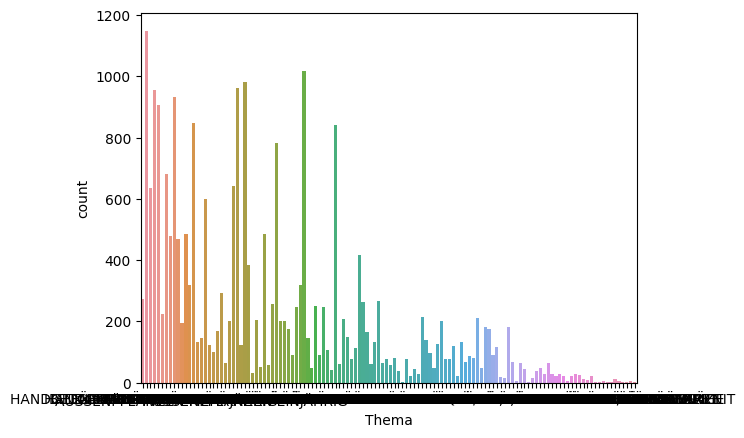

In [26]:
sns.countplot(x='Thema', data=umsatz_thema_best)

<AxesSubplot: xlabel='Unterthema', ylabel='Umsatz'>

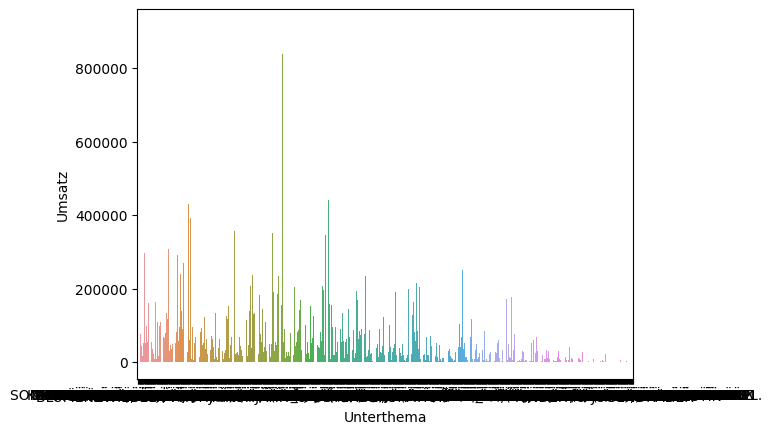

In [37]:
sns.barplot(x='Unterthema'
             , y='Umsatz'
             , data = umsatz_uthema
              ,estimator = np.sum
            ,errorbar=('ci', 0)
             ) 

<AxesSubplot: xlabel='Unterthema', ylabel='count'>

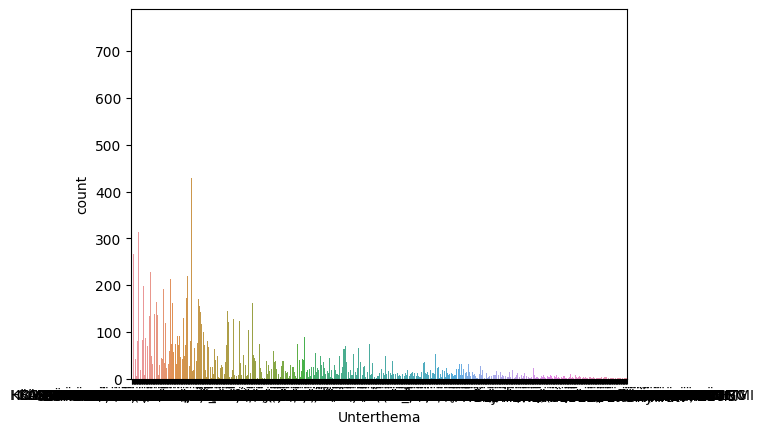

In [38]:
sns.countplot(x='Unterthema', data=umsatz_uthema_best)

In [39]:
#5. Kundensegmentierung mit K-Means 


##Zuerst auf eine BonID bringen

#Berechnung des letzten Einkaufs

kauf_info = kundeninfo.groupby(['Datum','KundenID', 'BonID'], as_index = False)['Umsatz'].sum()


kauf_info = kauf_info.sort_values(['KundenID','Datum'])
kauf_info['rank_Kauf'] = kauf_info.groupby(['KundenID'], as_index = False)['Datum'].cumcount(ascending=False) + 1

kauf_info_last = kauf_info.loc[kauf_info['rank_Kauf'] == 1]




kauf_info_last['LetzterKauf'] = (pd.to_datetime(max(kauf_info_last['Datum'])) - kauf_info_last['Datum'] ).dt.days



/var/folders/kk/fr7k343932n3kqg1j5mvwfmh0000gn/T/ipykernel_32998/4216996.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kauf_info_last['LetzterKauf'] = (pd.to_datetime(max(kauf_info_last['Datum'])) - kauf_info_last['Datum'] ).dt.days


In [40]:
#Berechnung der Frequenz

freq = kauf_info.groupby('KundenID')['Datum'].count()

ki_freq = pd.DataFrame(freq).reset_index()
ki_freq.columns = ['KundenID','Frequenz']


last_freq = ki_freq.merge(kauf_info_last,on='KundenID')


print(last_freq.loc[last_freq['KundenID'] == 22392])

       KundenID  Frequenz      Datum    BonID    Umsatz  rank_Kauf  \
22391     22392       702 2022-11-24  1453250  5.588785          1   

       LetzterKauf  
22391           37  


In [41]:
#Berechnung des Einkaufswerts


m = kauf_info.groupby('KundenID', as_index = False)['Umsatz'].sum()

m.columns = ['KundenID','Umsatz_Gesamt']

print(m.loc[m['KundenID'] == 22392])

       KundenID  Umsatz_Gesamt
22391     22392   38605.652173


In [42]:
#Data Frame zur Auswertung erstellen

rfm = m.merge(last_freq,on='KundenID')

finaldf = rfm[['KundenID','LetzterKauf','Frequenz','Umsatz_Gesamt']]

print(finaldf.loc[finaldf['KundenID'] == 22392])

       KundenID  LetzterKauf  Frequenz  Umsatz_Gesamt
22391     22392           37       702   38605.652173


LetzterKauf: 


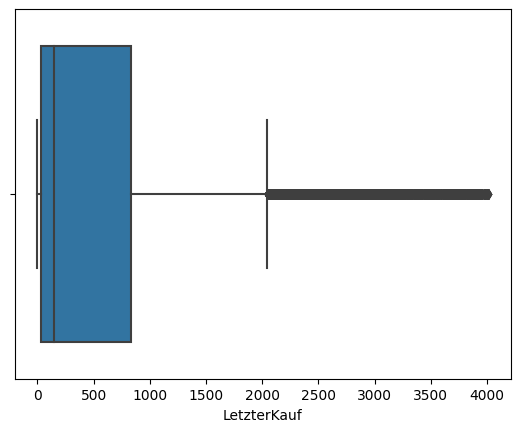

Frequenz: 


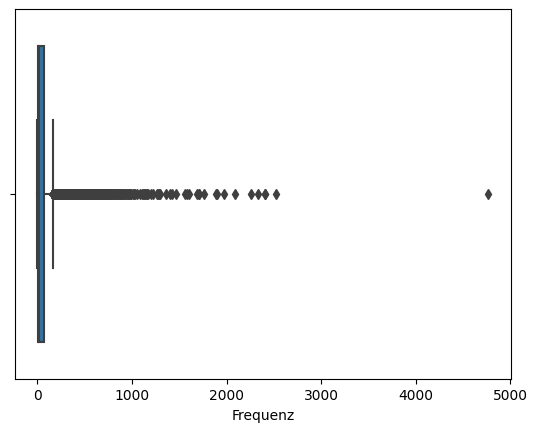

Umsatz_Gesamt: 


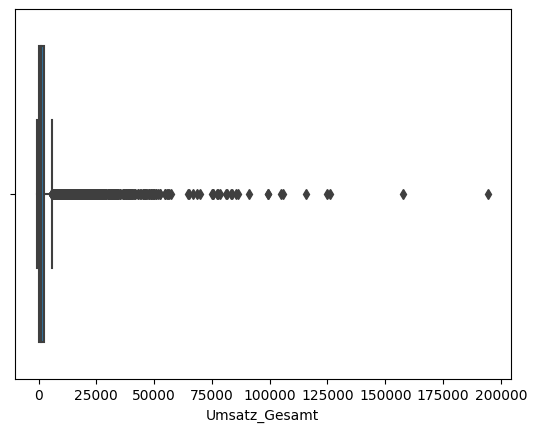

In [43]:
#Outliers löschen

import seaborn as sns
import matplotlib.pyplot as plt

list1 = ['LetzterKauf','Frequenz','Umsatz_Gesamt']
for i in list1:
    print(str(i)+': ')
    ax = sns.boxplot(x=finaldf[str(i)])
    plt.show()

In [45]:
from sklearn.preprocessing import StandardScaler

new_df = finaldf.drop_duplicates()
col_names = ['LetzterKauf','Frequenz','Umsatz_Gesamt']
features = new_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)

scaled_features.head()

,LetzterKauf,Frequenz,Umsatz_Gesamt
0,-0.586373,-0.472094,-0.439527
1,-0.592424,-0.346984,-0.395373
2,0.080457,-0.498903,-0.457535
3,0.585117,-0.186129,0.069024
4,-0.671088,0.841557,1.094221


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

Text(0, 0.5, 'Inertia')

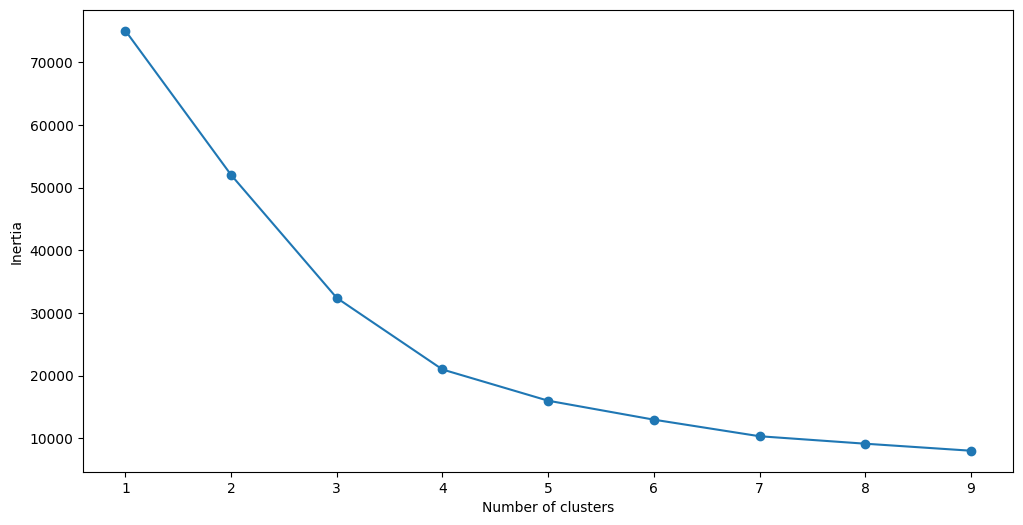

In [46]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(scaled_features)
    SSE.append(kmeans.inertia_)
    
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [47]:
# First, build a model with 3 clusters
kmeans = KMeans( n_clusters = 3, init='k-means++')
kmeans.fit(scaled_features)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [48]:
print(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

#Silhouette score:
    #3 Cluster: 0.54
    #4 Cluster: 0.50

    
# --> Choose 4 Cluster

0.5839901463959981


In [49]:
pred = kmeans.predict(scaled_features)
frame = pd.DataFrame(new_df)
frame['cluster'] = pred

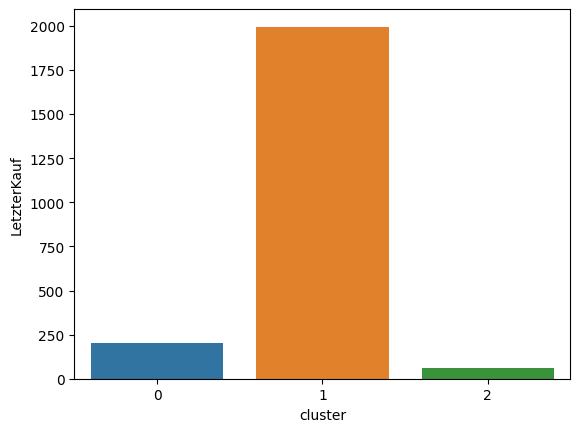

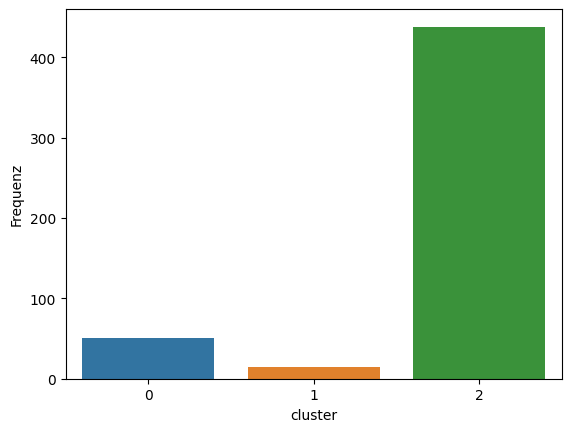

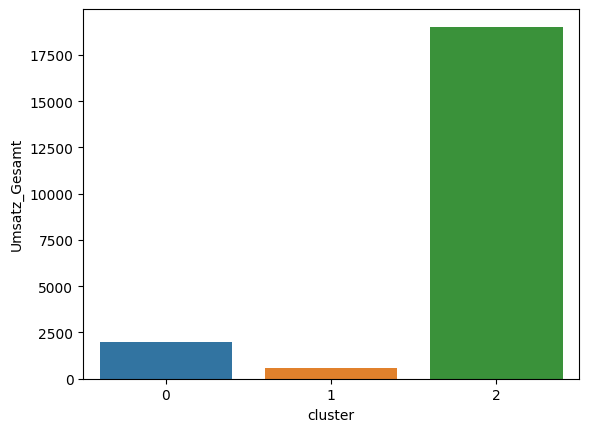

In [50]:
avg_df = frame.groupby(['cluster'], as_index=False).mean()
for i in list1:
    sns.barplot(x='cluster',y=str(i),data=avg_df)
    plt.show()

In [51]:
fig = px.scatter_3d(data_frame=frame, x="LetzterKauf", 
                    y="Umsatz_Gesamt", z="Frequenz", color="cluster", height=550,
                   title = "Ergebnis der Kundensegmentierung")
fig.show()

In [52]:
#Analyse aus KMeans

#Wie viele Pro Cluster -> was würden 10% in welchem Cluster mehr bringen

number = frame.groupby('cluster', as_index = False)['cluster'].count()


#Gesamt Umsatz pro Clust -> was würde 10% Umsatz steigerung bringen

umsatz = frame.groupby('cluster', as_index = False)['Umsatz_Gesamt'].sum()
